<font size="6"> **Exploratory Data Analysis** </font>

In [2]:
%%capture
%run 00_mlmod_load_data.ipynb

In [3]:
from sklearn.feature_selection import mutual_info_regression, SelectPercentile

In [4]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(io_utils.interim_path + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(io_utils.interim_path + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

In [5]:
print(features_full)

['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d', 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10', 'is_January', 'is_December', 'month_end', 'month_start', 'qtr_end', 'qtr_start', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4']


# Multicollinearity

In [6]:
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed']
quant_features = ['adv_120d', 'adv_20d', 'volatility_120d', 'volatility_20d', 
                  'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d']

In [7]:
all_factors[quant_features].describe().T

,count,mean,std,min,25%,50%,75%,max
adv_120d,361284.0,7.375182e-19,1.000001,-1.728520,-0.866027,0.000000,0.866027,1.728520
adv_20d,361284.0,7.375182e-20,1.000001,-1.728520,-0.866027,0.000000,0.866027,1.728520
volatility_120d,361284.0,1.258600e-05,0.999985,-1.728520,-0.866027,0.000000,0.866027,1.728520
volatility_20d,361284.0,4.182665e-06,0.999988,-1.728520,-0.866027,0.000000,0.866027,1.728520
dispersion_120d,361284.0,1.242492e-02,0.000629,0.008892,0.012028,0.012307,0.012706,0.017939
dispersion_20d,361284.0,1.257350e-02,0.001714,0.008892,0.011336,0.012314,0.013554,0.018303
market_vol_120d,361284.0,1.252853e-01,0.019350,0.086119,0.114585,0.120704,0.132684,0.184001
market_vol_20d,361284.0,1.216308e-01,0.043465,0.050347,0.092718,0.112689,0.143227,0.305171


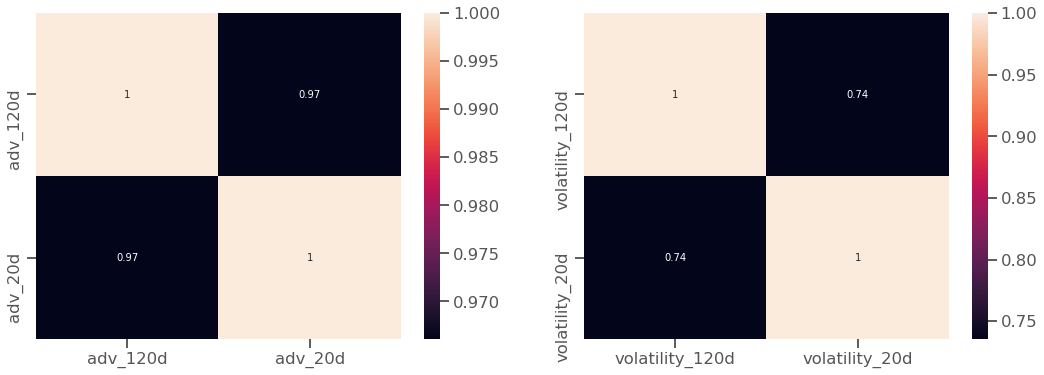

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
ax = axs[0]
sns.heatmap(all_factors[['adv_120d', 'adv_20d']].corr(),annot=True, ax=ax)
ax = axs[1]
sns.heatmap(all_factors[['volatility_120d', 'volatility_20d']].corr(),annot=True, ax=ax)

plt.show()

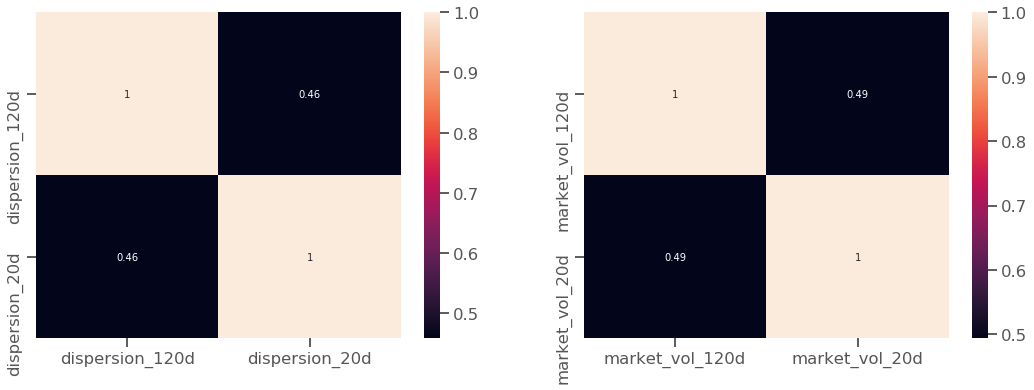

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
ax = axs[0]
sns.heatmap(all_factors[['dispersion_120d', 'dispersion_20d']].corr(),annot=True, ax=ax)
ax = axs[1]
sns.heatmap(all_factors[['market_vol_120d', 'market_vol_20d']].corr(),annot=True, ax=ax)

plt.show()

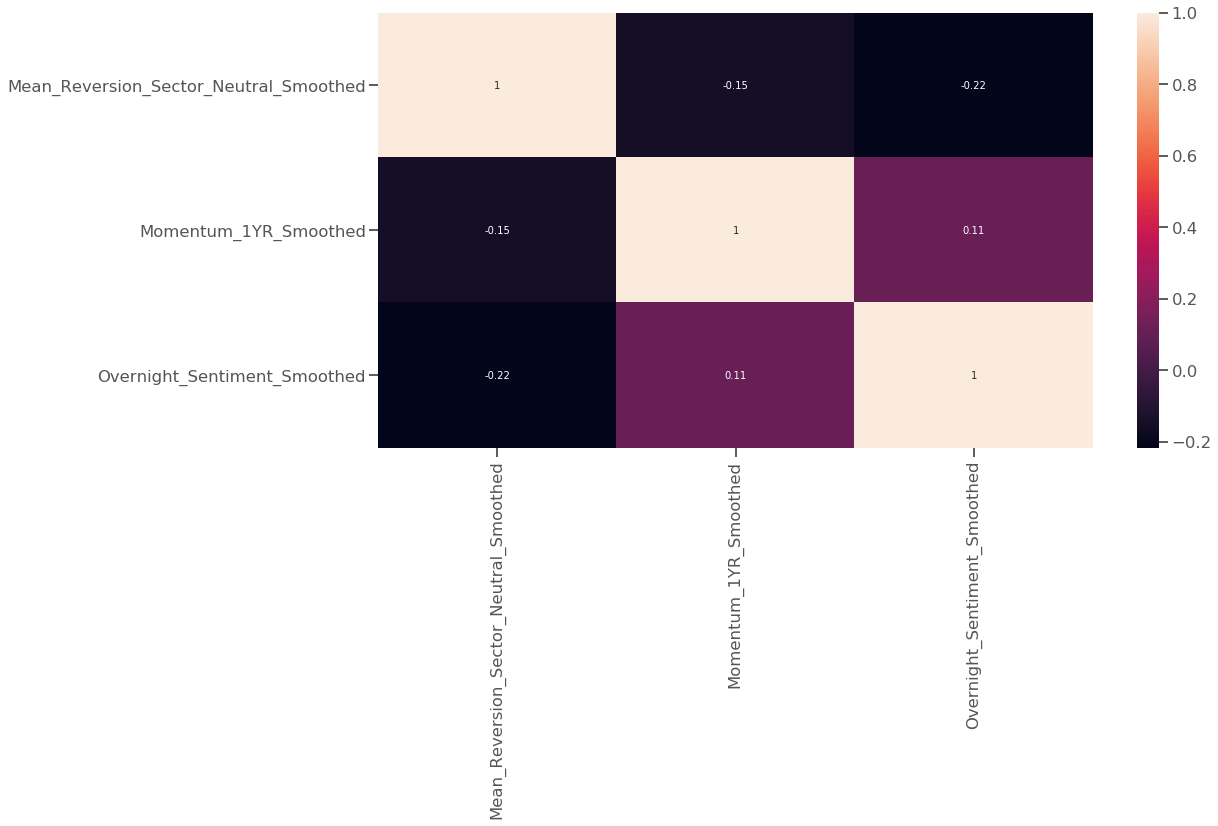

In [10]:
sns.heatmap(all_factors[alpha_factors].corr(),annot=True)
plt.show()

# Feature Ranking

## Correlation

In [15]:
features_full

['Mean_Reversion_Sector_Neutral_Smoothed',
 'Momentum_1YR_Smoothed',
 'Overnight_Sentiment_Smoothed',
 'adv_120d',
 'adv_20d',
 'dispersion_120d',
 'dispersion_20d',
 'market_vol_120d',
 'market_vol_20d',
 'volatility_120d',
 'volatility_20d',
 'sector_code_-1',
 'sector_code_0',
 'sector_code_1',
 'sector_code_2',
 'sector_code_3',
 'sector_code_4',
 'sector_code_5',
 'sector_code_6',
 'sector_code_7',
 'sector_code_8',
 'sector_code_9',
 'sector_code_10',
 'is_January',
 'is_December',
 'month_end',
 'month_start',
 'qtr_end',
 'qtr_start',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'qtr_1',
 'qtr_2',
 'qtr_3',
 'qtr_4']

In [13]:
corr = all_factors.corr('spearman').loc[features_full, target_col].to_frame('spearman')
corr['abs_spearman'] = abs(corr['spearman'])

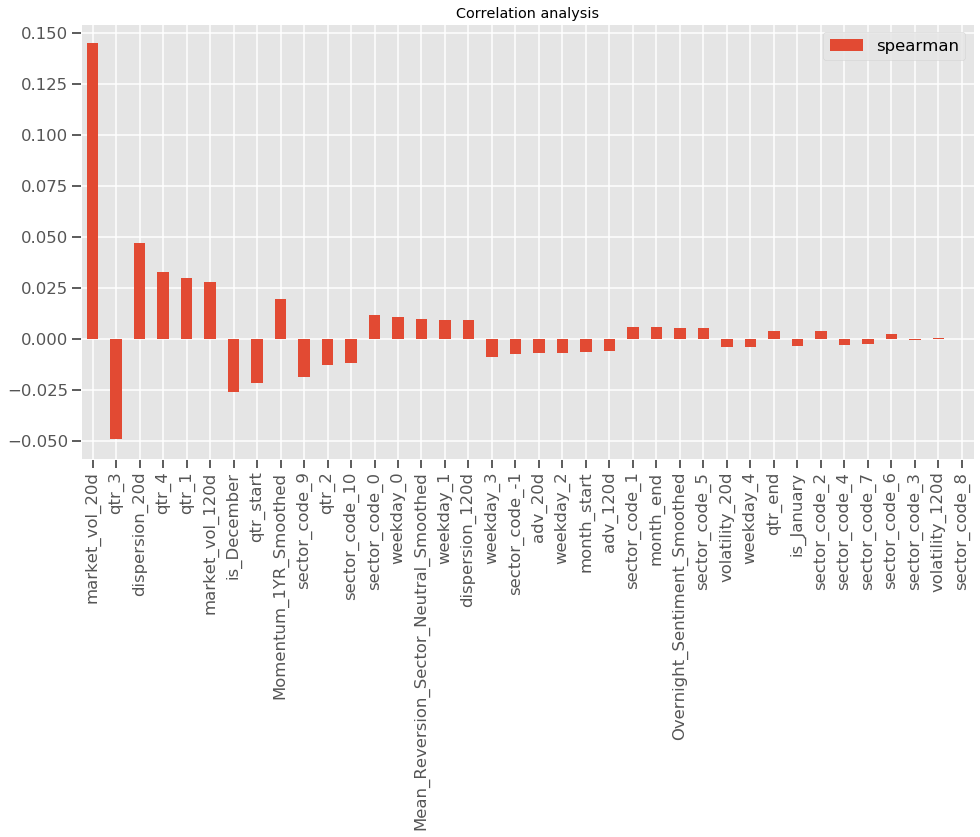

In [18]:
corr.sort_values(by='abs_spearman', ascending=False).plot.bar(y='spearman', title='Correlation analysis')
plt.show()

## Mutual Information 

In [19]:
sector_factor_df['weekday'] = sector_factor_df.index.get_level_values(0).weekday
sector_factor_df['qtr'] = sector_factor_df.index.get_level_values(0).quarter

In [23]:
features_cont = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed',
                 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d',
                 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d']
features_bin = ['is_January', 'is_December', 'month_end', 'month_start', 'qtr_end', 'qtr_start']
features_discr = features_bin + ['sector_code', 'weekday', 'qtr']

print('\tcontinuous: ', features_cont)
print('\tdiscrete: ', features_discr)

	continuous:  ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d']
	discrete:  ['is_January', 'is_December', 'month_end', 'month_start', 'qtr_end', 'qtr_start', 'sector_code', 'weekday', 'qtr']


In [27]:
X_train_smp_ord = X_train_smp[features_cont + features_bin].join(sector_factor_df)
features_is_discr = [col in features_discr for col in X_train_smp_ord.columns]
X_train_smp_ord.shape

(43191, 20)

In [28]:
mi = mutual_info_regression(X_train_smp_ord, y_train_smp, discrete_features=features_is_discr)

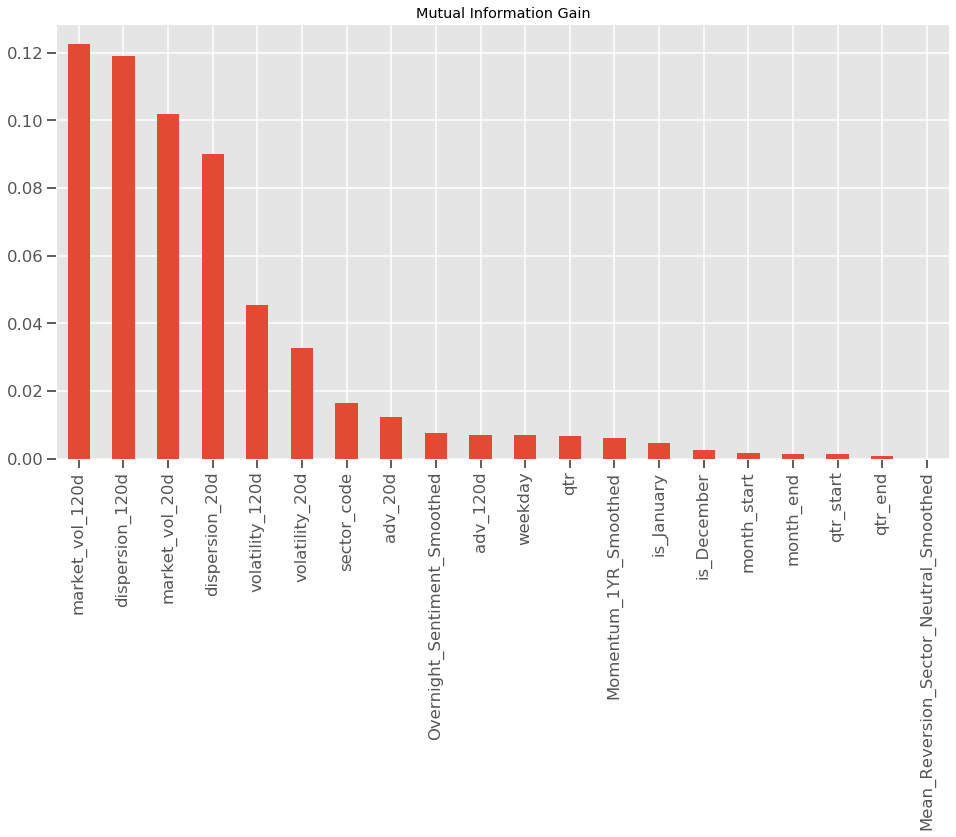

In [29]:
mi = pd.Series(index=X_train_smp_ord.columns.tolist(), data=mi).sort_values(ascending=False)
mi.plot.bar(title='Mutual Information Gain')
plt.show()

# Predictive Power

In [ ]:
all_factors_smp[['is_January',
 'is_December',
 'month_start',
 'month_end',
 'qtr_end',
 'qtr_start']].astype(str).describe()

In [ ]:
all_factors_smp.groupby('month_start')[target_col].mean()

In [ ]:
all_factors_smp.groupby('month_end')[target_col].mean()

In [ ]:
all_factors_smp.groupby('is_January')[target_col].mean()

In [ ]:
all_factors_smp.groupby('is_December')[target_col].mean()

In [ ]:
all_factors_smp.groupby('qtr_end')[target_col].mean()

In [ ]:
all_factors_smp.groupby('qtr_start')[target_col].mean()

In [ ]:
all_factors_smp.groupby('qtr_1')[target_col].mean()

In [ ]:
all_factors_smp.groupby('qtr_2')[target_col].mean()

In [ ]:
all_factors_smp.groupby('qtr_3')[target_col].mean()

In [ ]:
all_factors_smp.groupby('qtr_4')[target_col].mean()

In [ ]:
selector = SelectPercentile(score_func=mutual_info_regression(), percentile=100,)
selector_fit = selector.fit(X_train_smp, y_train_smp)

# Alpha and Quant Factors Accuracy Baseline

In [ ]:
all_factors[['adv_120d', 'volatility_120d', 'dispersion_120d', 'market_vol_120d']].describe()

In [ ]:
def compute_acc_metrics_by_feature(data, features):
    alphas_acc = pd.DataFrame(columns=['wacc', 'acc', 'acc_up', 'acc_down'], dtype=float)
   
    for alpha_fac in features:
        alphas_acc.loc[alpha_fac, 'wacc'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
        alphas_acc.loc[alpha_fac, 'acc'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='global')
        alphas_acc.loc[alpha_fac, 'acc_up'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='upwards')
        alphas_acc.loc[alpha_fac, 'acc_down'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='downwards')
        
    return alphas_acc

def compute_wacc_by_yr(data, features):
    yrs_idx = data.index.get_level_values(0).year
    yr_lst = yrs_idx.unique()
    alphas_wacc_by_yr = pd.DataFrame(index = yr_lst, dtype=float)
    
    for alpha_fac in features:
        alphas_wacc_by_yr[alpha_fac] = data.groupby(yrs_idx)[[target_col, alpha_fac]].apply(
            lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
        )
        
    return alphas_wacc_by_yr


In [ ]:
alphas_acc = compute_acc_metrics_by_feature(all_factors, )
alphas_acc

In [ ]:
features_ohe = ['is_January', 'is_December', 'month_start', 'month_end', 'qtr_end', 'qtr_start',
 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10',
 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']
ohe_factors = all_factors[features_ohe].replace(0,-1).join(all_factors[target_col]) 
ohe_feats_acc = compute_acc_metrics_by_feature(ohe_factors,  features_ohe)
ohe_feats_acc

In [ ]:
alphas_acc = pd.DataFrame(columns=['wacc', 'acc', 'acc_up', 'acc_down'], dtype=float)
yr_lst = all_factors.index.get_level_values(0).year.unique()
alphas_wacc_by_yr = pd.DataFrame(index = yr_lst, dtype=float)
for alpha_fac in:
    alphas_acc.loc[alpha_fac, 'wacc'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
    alphas_acc.loc[alpha_fac, 'acc'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='global')
    alphas_acc.loc[alpha_fac, 'acc_up'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='upwards')
    alphas_acc.loc[alpha_fac, 'acc_down'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='downwards')
    
    alphas_wacc_by_yr[alpha_fac] = all_factors.groupby(all_factors.index.get_level_values(0).year)[[target_col, alpha_fac]].apply(
        lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
    )

alphas_acc

In [ ]:
alphas_acc = pd.DataFrame(columns=['wacc', 'acc', 'acc_up', 'acc_down'], dtype=float)
yr_lst = all_factors.index.get_level_values(0).year.unique()
alphas_wacc_by_yr = pd.DataFrame(index = yr_lst, dtype=float)
for alpha_fac in ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed']:
    alphas_acc.loc[alpha_fac, 'wacc'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
    alphas_acc.loc[alpha_fac, 'acc'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='global')
    alphas_acc.loc[alpha_fac, 'acc_up'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='upwards')
    alphas_acc.loc[alpha_fac, 'acc_down'] = mle_utils.direction_accuracy_func(
        y_true=all_factors[target_col], y_pred=all_factors[alpha_fac], kind='downwards')
    
    alphas_wacc_by_yr[alpha_fac] = all_factors.groupby(all_factors.index.get_level_values(0).year)[[target_col, alpha_fac]].apply(
        lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
    )

alphas_acc

In [ ]:
alphas_wacc_by_yr = compute_wacc_by_yr(all_factors, ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed'])

In [ ]:
ax = alphas_wacc_by_yr.plot()
ax.locator_params(integer=True)

In [ ]:
features = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed', 'adv_20d',
       'dispersion_120d', 'dispersion_20d', 'market_vol_120d','market_vol_20d', 'volatility_20d',
       'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2',
       'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6',
       'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10',
        'is_December', 'qtr_end', 'qtr_start']

In [ ]:
features_nov = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed',
 'adv_120d', 'adv_20d',
 'dispersion_120d', 'dispersion_20d',
 'market_vol_120d', 'market_vol_20d',
 'volatility_120d', 'volatility_20d',
 'is_January', 'is_December',
 'month_start', 'month_end',
 'qtr_end', 'qtr_start',
 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2',
 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6',
 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10',
 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4']